In [1]:
import numpy as np
import seaborn as sns
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from utils import calculate_dissim, laplacian_dissim
from myst_nb import glue

# Comparing Discriminability - Mice

Here we construct a basic pipeline of comparing some simple graph kernels using discriminability.

First, we load in 32 networks that were generated from MRI scans of mice brains, provided by [Graspologic](https://microsoft.github.io/graspologic/latest/index.html). The mice came from 4 different genotypes, and there were 8 mice per genotype. 

## Load Data

In [2]:
from graspologic.datasets import load_mice

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

# initialize labels
labels = {}
for i in np.arange(0, 332):
    labels[i] = i

(32, 332, 332)


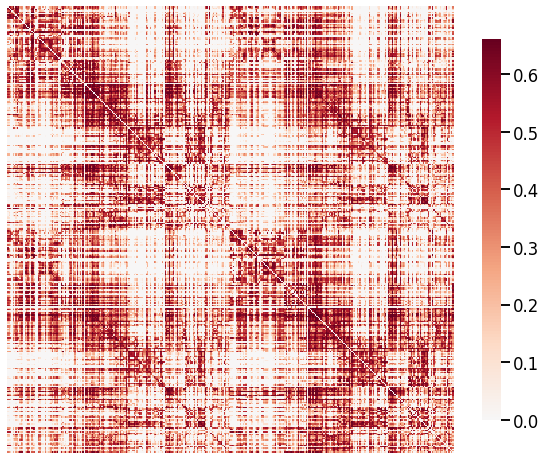

In [5]:
# Visualize one of the graphs
ax = heatmap(graphs[0], context='talk', transform='simple-all')
ax.figure.set_facecolor('w')

## Kernels

The following is a list of kernels that were implemented. We divided them into three major groups based on the metrics used.

- Global: Density, Average Edge Weight, Average of Adjacency Matrix
- Node-wise: Node Degree (L1, L2 Norm), Node Strength (L1, L2 Norm)
- Edge-wise: Edge Weights (L1, L2 Norm)

## Global Kernels

The following kernels are constructed using characteristics of the entire graph. For each metric, the absolute differences between every pair of graphs were calculated and visualized using a heatmap.

### Density
The density of each graph was calculated by dividing the number of edges by the number of possible nodes.

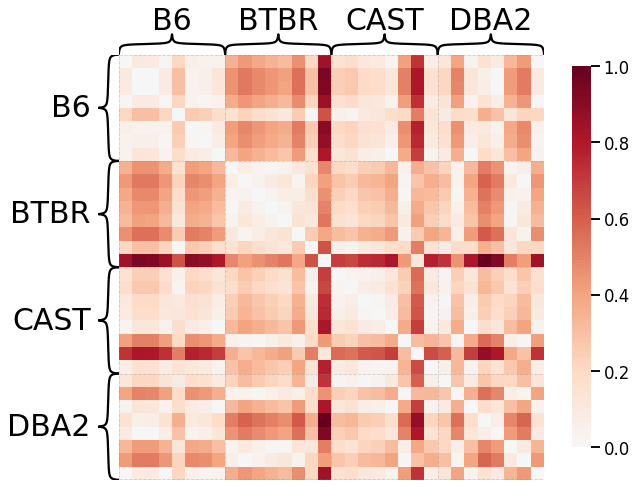

In [3]:
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

ax = heatmap(scaled_density_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Average Edge Weight

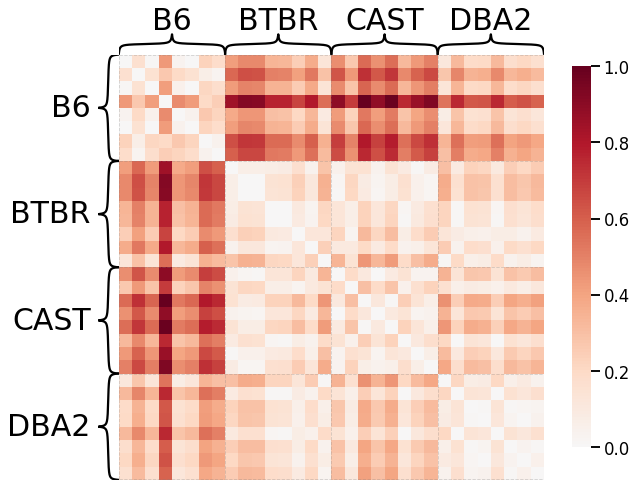

In [4]:
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

ax = heatmap(scaled_avgedgeweight_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Average of the Adjacency Matrix
Note that when we calculate the average of each adjacency matrix, we include edges that do not exist, whereas we only consider those with nonzero values when we calculate the average edge weight of each graph.

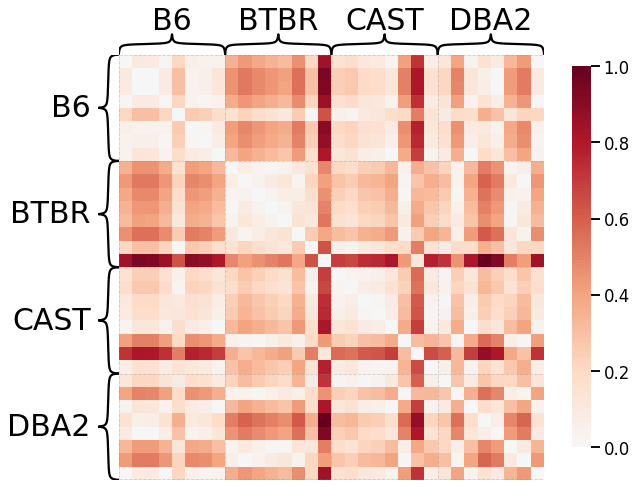

In [5]:
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

ax = heatmap(scaled_avgadjmat_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Spectral Distance (Laplacian)

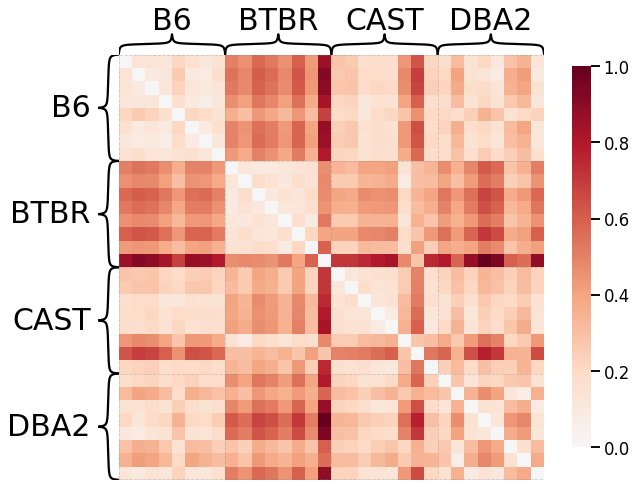

In [6]:
scaled_lap_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l2', normalize=True)

ax = heatmap(scaled_lap_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Node-wise Kernels
The following kernels use characteristics related to the nodes of each graph. For each metric, we calculate a difference vector between every pair of graphs, then compute and visulize the L1 and L2 norms of the difference vector using a heatmap.

### Node Degrees - L1 Norm
The degree of a node in a graph is the number of nodes each node is adjacent to, aka the number of edges each node has.

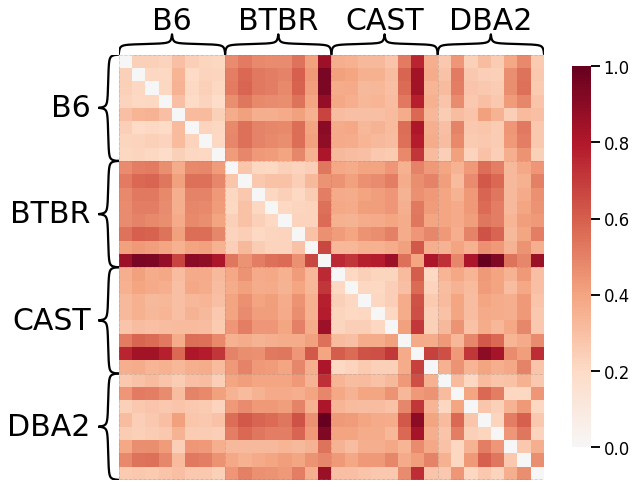

In [7]:
scaled_nodedeg_dissim_l1 = calculate_dissim(graphs, method="degree", norm="l1", normalize=True)

ax = heatmap(scaled_nodedeg_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Degrees - L2 Norm

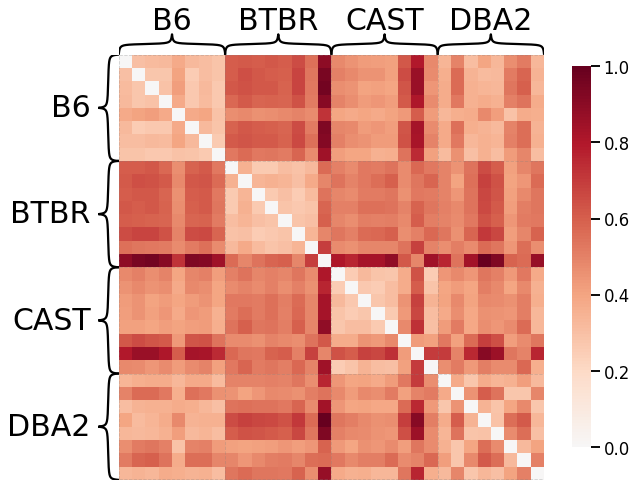

In [8]:
scaled_nodedeg_dissim_l2 = calculate_dissim(graphs, method="degree", norm="l2", normalize=True)

ax = heatmap(scaled_nodedeg_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Strength - L1 Norm
Node strength, unlike node degree, takes into account the weight of the edges each node has. We calculate node strength by finding the sum of the edge weights for each node.

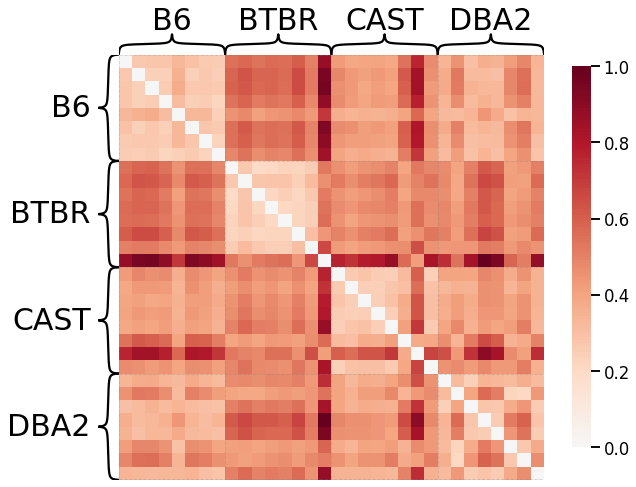

In [9]:
scaled_nodestr_dissim_l1 = calculate_dissim(graphs, method="strength", norm="l1", normalize=True)

ax = heatmap(scaled_nodestr_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Strength - L2 Norm

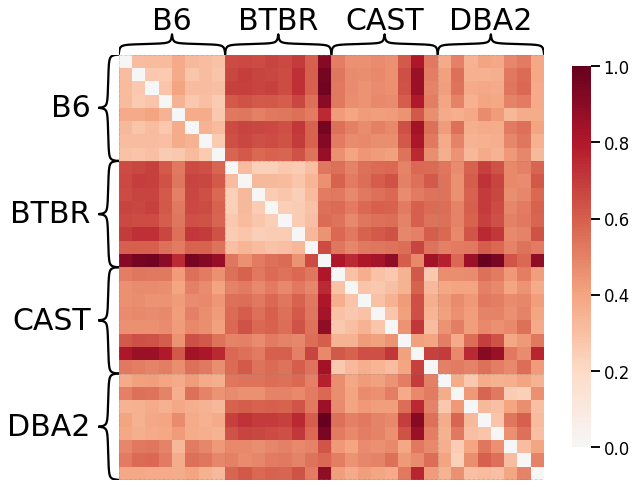

In [10]:
scaled_nodestr_dissim_l2 = calculate_dissim(graphs, method="strength", norm="l2", normalize=True)

ax = heatmap(scaled_nodestr_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Edge-wise Kernels
The following kernels use characteristics related to the edges of each graph. For each metric, we calculate a difference vector between every pair of graphs, then compute and visulize the L1 and L2 norms of the difference vector using a heatmap.

### Edge weights - L1 Norm
Here we compare the weights of each edge between graphs by simply subtracting one adjacency matrix from another.

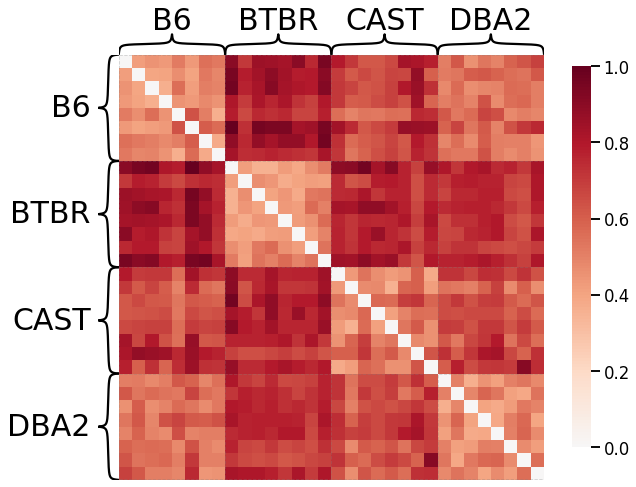

In [11]:
scaled_edgeweight_dissim_l1 = calculate_dissim(graphs, method="edgeweight", norm="l1", normalize=True)

ax = heatmap(scaled_edgeweight_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Edge Weights - L2 Norm

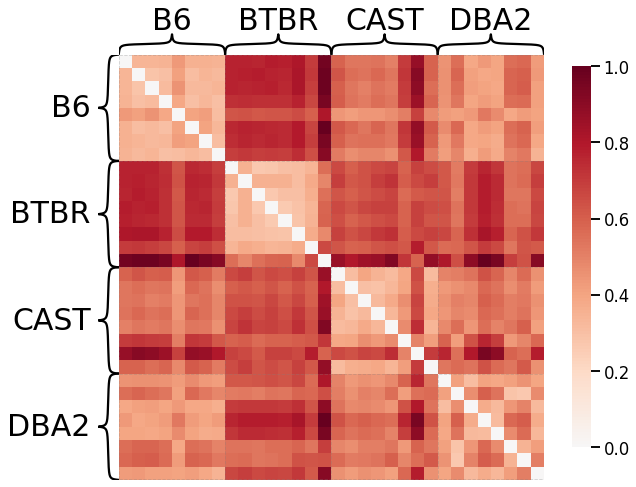

In [12]:
scaled_edgeweight_dissim_l2 = calculate_dissim(graphs, method="edgeweight", norm="l2", normalize=True)

ax = heatmap(scaled_edgeweight_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Omnibus Embedding

Here we use omnibus embedding in order to provide a comparison to a well-established kernel.

In [13]:
from graspologic.embed import OmnibusEmbed

# Embed using Omni
embedder = OmnibusEmbed(n_elbows=4)
omni_embedding = embedder.fit_transform(graphs)
print(omni_embedding.shape)

(32, 332, 10)


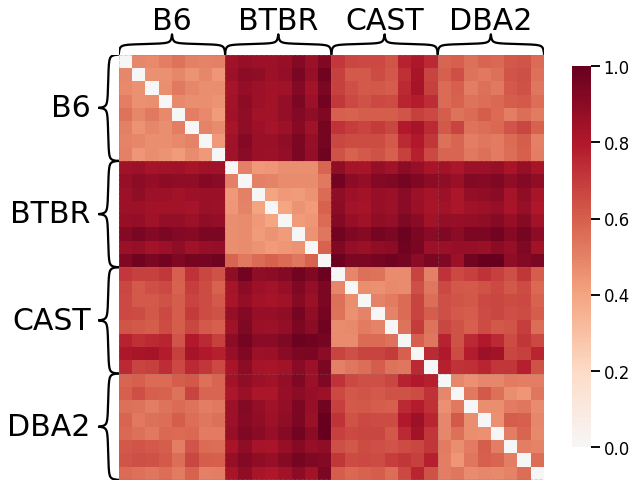

In [14]:
# create dissimilarity matrix
omni_matrix = np.zeros((len(graphs), len(graphs)))
for i, embedding1 in enumerate(omni_embedding):
    for j, embedding2 in enumerate(omni_embedding):
        dist = np.linalg.norm(embedding1 - embedding2, ord="fro")
        omni_matrix[i, j] = dist

# plot heatmap
scaled_omni_dissim = omni_matrix / np.max(omni_matrix)

ax = heatmap(scaled_omni_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Discriminability Plot

We will use the [One Sample Discriminability](https://mgc.neurodata.io/api/generated/hyppo.discrim.discrimonesample) test from [hyppo](https://mgc.neurodata.io/index.html) to compare the performance of each kernel. The distance matrix of the embeddings ater using Omnibus is included as a point of comparison.

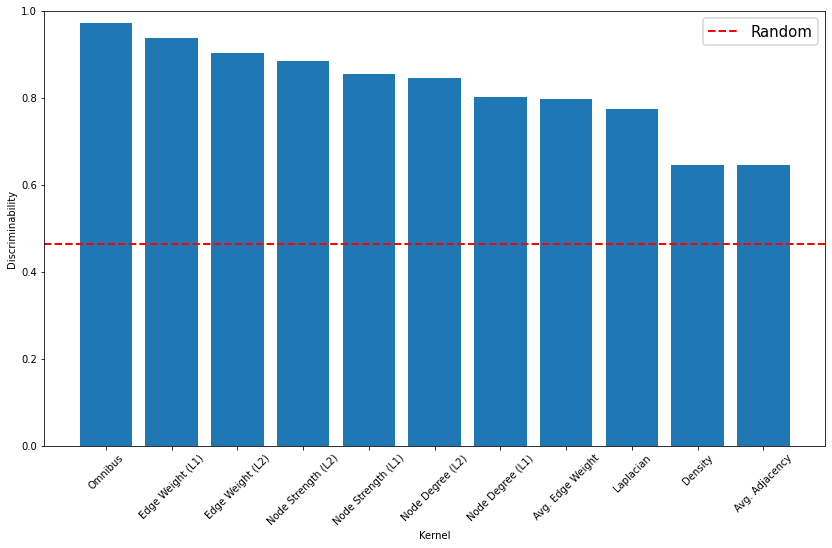

In [15]:
# HIDE CODE

from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# construct random matrix with zero diagonal
np.random.seed(3)
scaled_random = np.random.rand(len(graphs), len(graphs))
np.fill_diagonal(scaled_random, 0)

# calculate discriminability for each kernel matrix
discrim_omni = discrim.statistic(scaled_omni_dissim, y)
discrim_density = discrim.statistic(scaled_density_dissim, y)
discrim_avgedgeweight = discrim.statistic(scaled_avgedgeweight_dissim, y)
discrim_avgadjmat = discrim.statistic(scaled_avgadjmat_dissim, y)
discrim_lap = discrim.statistic(scaled_lap_dissim, y)
discrim_nodedeg_l1 = discrim.statistic(scaled_nodedeg_dissim_l1, y)
discrim_nodedeg_l2 = discrim.statistic(scaled_nodedeg_dissim_l2, y)
discrim_nodestr_l1 = discrim.statistic(scaled_nodestr_dissim_l1, y)
discrim_nodestr_l2 = discrim.statistic(scaled_nodestr_dissim_l2, y)
discrim_edgeweight_l1 = discrim.statistic(scaled_edgeweight_dissim_l1, y)
discrim_edgeweight_l2 = discrim.statistic(scaled_edgeweight_dissim_l2, y)
discrim_random = discrim.statistic(scaled_random, y)

# plot bar graph in descending order
kernels = ['Omnibus', 'Density', 'Avg. Edge Weight', 'Avg. Adjacency', 'Laplacian', 'Node Degree (L1)', 'Node Degree (L2)', \
    'Node Strength (L1)', 'Node Strength (L2)', 'Edge Weight (L1)', 'Edge Weight (L2)']
stats = [discrim_omni, discrim_density, discrim_avgedgeweight, discrim_avgadjmat, discrim_lap, discrim_nodedeg_l1, discrim_nodedeg_l2, \
    discrim_nodestr_l1, discrim_nodestr_l2, discrim_edgeweight_l1, discrim_edgeweight_l2]

discrim_dict = {}
for i, kernel in enumerate(kernels):
    discrim_dict[kernel] = stats[i]

sorted_discrim_dict = dict(sorted(discrim_dict.items(), key=lambda x:x[1], reverse=True))

mice_discrim_fig, ax = plt.subplots(figsize=(14,8), facecolor='w')
mice_discrim_fig = sns.set_context("talk", font_scale=0.9)
plt.bar(list(sorted_discrim_dict.keys()), list(sorted_discrim_dict.values()))
plt.axhline(y=discrim_random, color='r', linestyle='--', linewidth=2, label='Random')
plt.xticks(rotation=45, horizontalalignment='center')
plt.ylim([0, 1.0])
plt.xlabel('Kernel')
plt.ylabel('Discriminability')
plt.legend()

glue("mice_discrim", mice_discrim_fig, display=False)